# Indicadores de Manutenção - Linha de Pintura Contínua

In [58]:
import sys
sys.path.insert(1, r'\\csnprarq1\Comum\Corporacao\GPC\04- LPC\Python')

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import calendar
from matplotlib import dates
import bannwart_v1 as bann
import datetime as dt 

%matplotlib inline  

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [59]:
def responsabilidades(df):           
    df['Modalidade'] = 'Externas'
    mask = df['Desc. Un. Resp. (PE)'].str.contains('PP-') == True
    column_name = 'Modalidade'
    df.loc[mask, column_name] = 'Setup'

    mask = df['Desc. Un. Resp. (PE)'].str.contains('ST-') == True
    column_name = 'Modalidade'
    df.loc[mask, column_name] = 'Setup'

    mask = df['Desc. Un. Resp. (PE)'].str.contains('FT-') == True
    column_name = 'Modalidade'
    df.loc[mask, column_name] = 'Setup'

    mask = df['Desc. Un. Resp. (PE)'].str.contains('OP-') == True
    column_name = 'Modalidade'
    df.loc[mask, column_name] = 'Operação'

    mask = df['Desc. Un. Resp. (PE)'].str.contains('MA-') == True
    column_name = 'Modalidade'
    df.loc[mask, column_name] = 'Manutenção'

    mask = df['Desc. Un. Resp. (PE)'].str.contains('MM-') == True
    column_name = 'Modalidade'
    df.loc[mask, column_name] = 'Manutenção'

    mask = df['Desc. Un. Resp. (PE)'].str.contains('MI-') == True
    column_name = 'Modalidade'
    df.loc[mask, column_name] = 'Manutenção'

    mask = df['Desc. Un. Resp. (PE)'].str.contains('ME-') == True
    column_name = 'Modalidade'
    df.loc[mask, column_name] = 'Manutenção'

    mask = df['Desc. Un. Resp. (PE)'].str.contains('INST') == True
    column_name = 'Modalidade'
    df.loc[mask, column_name] = 'Manutenção'


    mask = df['Desc. Motivo Parada (PE)'].str.contains('PREVE') == True
    column_name = 'Modalidade'
    df.loc[mask, column_name] = 'Manutenção'
    df.loc[mask,'Desc. Un. Resp. (PE)'] = 'MP'

    mask = df['Desc. Motivo Parada (PE)'].str.contains('GERA') == True
    column_name = 'Modalidade'
    df.loc[mask, column_name] = 'Manutenção'
    df.loc[mask,'Desc. Un. Resp. (PE)'] = 'RG'

    mask = df['Desc. Motivo Parada (PE)'].str.contains('NP-') == True
    column_name = 'Modalidade'
    df.loc[mask, column_name] = 'Não programada'

    return df

def emenda_paradas(df):
           
    df['Corr'] = df['Dt. Início (PE)'] + pd.to_timedelta(df['Tempo Parada Calculada (PE)'], unit='m')
    
    df['emenda'] = np.where((df['Dt. Início (PE)'] == df['Dt. Fim (PE)'].shift()) & (df['Desc. Motivo Parada (PE)'] == df['Desc. Motivo Parada (PE)'].shift()), 1, 0)            
    df.loc[(df['emenda']==0) & (df['emenda'].shift(-1)==1), 'emenda'] = 1

    df['grupo'] = 0
    df['grupo'] = df['grupo'].mask(df['emenda'] == 0, 'N' + df['emenda'].diff().fillna(df['emenda']).eq(0).cumsum().astype(str))
    df['grupo'] = df['grupo'].mask(df['emenda'] == 1, 'E' + df['emenda'].diff().fillna(df['emenda']).eq(-1).cumsum().astype(str))

    df['Acumulado'] = df.groupby('grupo')['Tempo Parada Calculada (PE)'].cumsum()

    df = df.groupby(['grupo']).agg({'Dt. Início (PE)':'first',
                                    'Dt. Fim (PE)':'last',
                                    'Tempo Parada Calculada (PE)':'sum',
                                    'Desc. Un. Resp. (PE)':'first',
                                    'Desc. Motivo Parada (PE)':'first',
                                    'Observação (PE)':'first',
                                    'Equipe (PE)':'first',
                                    'Semana':'first',
                                    'Causa Externa (PE)':'first',
                                    'Modalidade':'first',
                                    'Corr':'first',
                                    'emenda':'first',
                                    'Acumulado':'first'})

    df = df.drop(['Corr','emenda','Acumulado'],axis=1)
    
    return df

def troca_nome(df):
    df.loc[df['Desc. Un. Resp. (PE)'].str.contains("ME-MANUTENCAO ELETRICA"),'Desc. Un. Resp. (PE)'] = 'ME'
    df.loc[df['Desc. Un. Resp. (PE)'].str.contains("MM-MANUTENCAO MECANICA"),'Desc. Un. Resp. (PE)'] = 'MM'
    df.loc[df['Desc. Un. Resp. (PE)'].str.contains("MA-MANUTENCAO AUTOMACAO"),'Desc. Un. Resp. (PE)'] = 'MA'
    df.loc[df['Desc. Un. Resp. (PE)'].str.contains("IN- INSTRUMENTACAO"),'Desc. Un. Resp. (PE)'] = 'IN'
    return df

def colors_from_values(values, palette_name):
    # normalize the values to range [0, 1]           
    minimo = np.amin(values)
    maximo = np.amax(values)
    normalized = (values - minimo) / (maximo - minimo)
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    
    return np.array(palette).take(indices, axis=0)

In [60]:
df_o = pd.read_parquet(r'I:\Corporacao\GPC\04- LPC\Python\Dados\Paradas.parquet')

df_o = responsabilidades(df_o) # insere coluna (Modalidade) com informações de Manutenção,setup,operação a
df_o = emenda_paradas(df_o) # une as paradas que foram quebradas as 6:30 e 18:30
df_o = df_o.loc[df_o['Modalidade']=='Manutenção']
df_o = troca_nome(df_o) # troca por responsabilidades MM, ME, MA, e IN
df_o['Ano_mes'] = df_o['Dt. Início (PE)'].dt.strftime('%Y-%m')
df_o['Ano'] = df_o['Dt. Início (PE)'].dt.strftime('%Y')

df_o = df_o.reset_index()
df_o = df_o.sort_values(by='Dt. Início (PE)')
df_o = df_o.drop(columns=['grupo'])
df_o.index = range(0,df_o.shape[0])


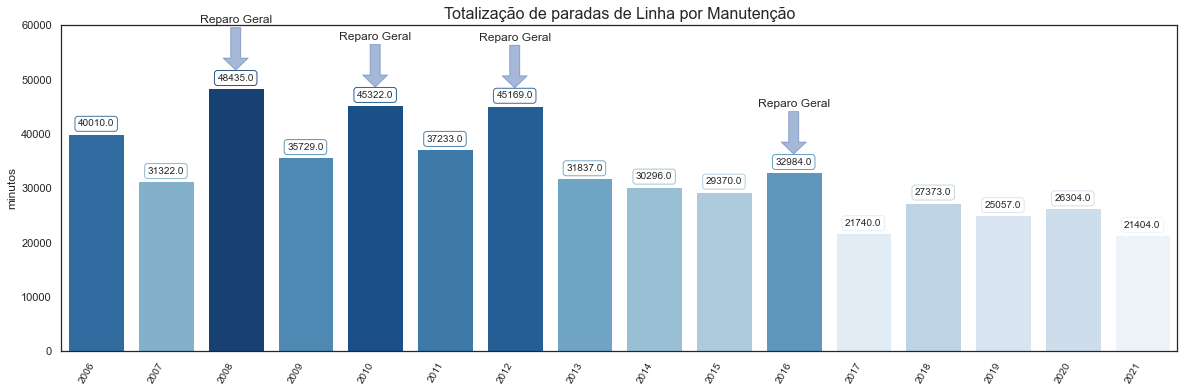

In [61]:
df = df_o

df = df.loc[df['Dt. Início (PE)']>'2006-01-01']

df['Regime'] = 'Emergencia'

df.loc[df['Desc. Un. Resp. (PE)']=='RG','Regime'] = 'Programado'
df.loc[df['Desc. Un. Resp. (PE)']=='MP','Regime'] = 'Programado'

#df = df.loc[df['Regime'] == 'Programado']

f, ax = plt.subplots(figsize=(20,6))

df = df.groupby(['Ano']).sum()
df = df.reset_index()

def pallete_bann(df,coluna,pallete_cor):
    pal = sns.color_palette(pallete_cor, len(df))
    rank = df[coluna].argsort().argsort() 
    pallete = np.array(pal[::-1])[rank]
    
    return pallete


sns.barplot(x='Ano',y='Tempo Parada Calculada (PE)',data=df,ax=ax,palette=pallete_bann(df,'Tempo Parada Calculada (PE)','Blues_r'))



ax.set_xticklabels(ax.get_xticklabels(),rotation=60, ha='right', fontsize = 10)
titulo = 'Totalização de paradas de Linha por Manutenção'
ax.set_title(titulo, fontsize=16)
ax.set_xlabel('', fontsize=12)
ax.set_ylabel('minutos', fontsize=12)
ax.set(ylim=(0,60000))
     
for p in ax.patches:
    ax.annotate(p.get_height(), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center',
                   va = 'center', 
                   size=10,
                   xytext = (0, + 10), 
                   textcoords = 'offset points',
                   bbox=dict(boxstyle='round', fc='w',ec=p.get_facecolor(),alpha=0.9),
                  )
i = 0
for p in ax.patches:
    if ((i==2)or(i==4)or(i==6)or(i==10)):
        ax.annotate('Reparo Geral', 
                       (p.get_x() + p.get_width() / 2., p.get_height()+3300), 
                       ha = 'center',
                       va = 'center', 
                       size=12,
                       xytext = (0, + 50), 
                       textcoords = 'offset points',
                       arrowprops=dict(fc='b',ec = 'b',alpha=0.5, shrink=10, headwidth=25, width=10)
                      )
    i = i+1
    

None

In [62]:
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

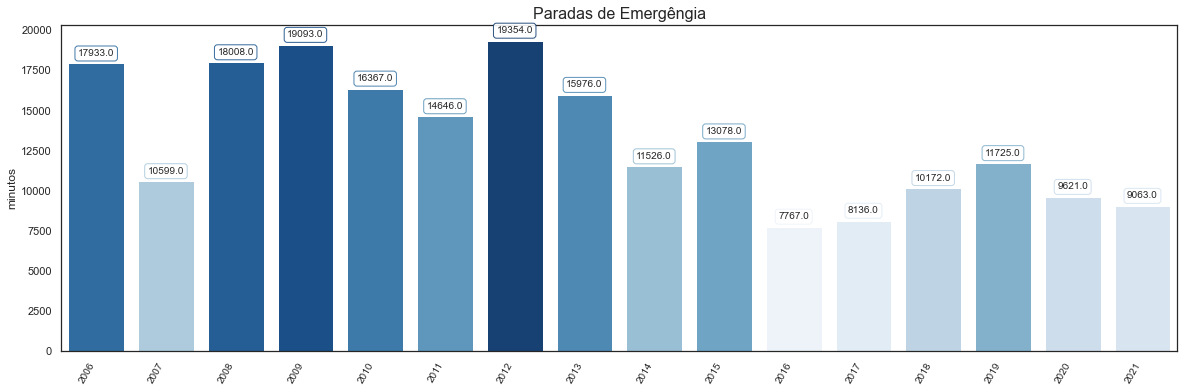

In [63]:
df = df_o

df = df.loc[df['Dt. Início (PE)']>'2006-01-01']

df['Regime'] = 'Emergencia'

df.loc[df['Desc. Un. Resp. (PE)']=='RG','Regime'] = 'Programado'
df.loc[df['Desc. Un. Resp. (PE)']=='MP','Regime'] = 'Programado'

df = df.loc[df['Regime'] == 'Emergencia']

sns.set_style('white')
f, ax = plt.subplots(figsize=(20,6))

df = df.groupby(['Ano']).sum()
df = df.reset_index()

def pallete_bann(df,coluna,pallete_cor):
    pal = sns.color_palette(pallete_cor, len(df))
    rank = df[coluna].argsort().argsort() 
    pallete = np.array(pal[::-1])[rank]
    
    return pallete


sns.barplot(x='Ano',y='Tempo Parada Calculada (PE)',data=df,ax=ax,palette=pallete_bann(df,'Tempo Parada Calculada (PE)','Blues_r'))


str1 = " " 

ax.set_xticklabels(ax.get_xticklabels(),rotation=60, ha='right', fontsize = 10)
titulo = 'Paradas de Emergêngia'
ax.set_title(titulo, fontsize=16)
ax.set_xlabel('', fontsize=12)
ax.set_ylabel('minutos', fontsize=12)

     
for p in ax.patches:
    ax.annotate(p.get_height(), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center',
                   va = 'center', 
                   size=10,
                   xytext = (0, + 10), 
                   textcoords = 'offset points',
                   bbox=dict(boxstyle='round', fc='w',ec=p.get_facecolor(),alpha=0.9),                      
                  )



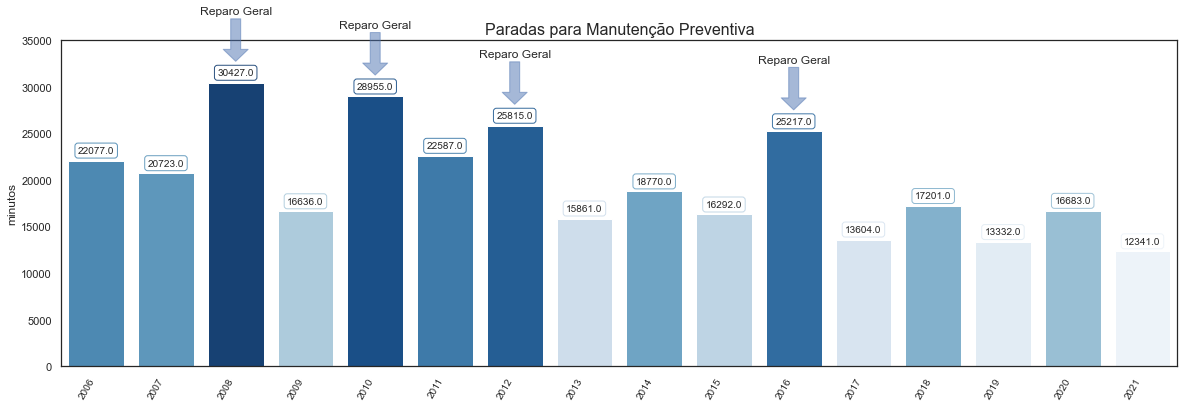

In [64]:
df = df_o

df = df.loc[df['Dt. Início (PE)']>'2006-01-01']

df['Regime'] = 'Emergencia'

df.loc[df['Desc. Un. Resp. (PE)']=='RG','Regime'] = 'Programado'
df.loc[df['Desc. Un. Resp. (PE)']=='MP','Regime'] = 'Programado'

df = df.loc[df['Regime'] == 'Programado']

f, ax = plt.subplots(figsize=(20,6))

df = df.groupby(['Ano']).sum()
df = df.reset_index()

def pallete_bann(df,coluna,pallete_cor):
    pal = sns.color_palette(pallete_cor, len(df))
    rank = df[coluna].argsort().argsort() 
    pallete = np.array(pal[::-1])[rank]
    
    return pallete


sns.barplot(x='Ano',y='Tempo Parada Calculada (PE)',data=df,ax=ax,palette=pallete_bann(df,'Tempo Parada Calculada (PE)','Blues_r'))



ax.set_xticklabels(ax.get_xticklabels(),rotation=60, ha='right', fontsize = 10)
titulo = 'Paradas para Manutenção Preventiva'
ax.set_title(titulo, fontsize=16)
ax.set_xlabel('', fontsize=12)
ax.set_ylabel('minutos', fontsize=12)
ax.set(ylim=(0,35000))
     
for p in ax.patches:
    ax.annotate(p.get_height(), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center',
                   va = 'center', 
                   size=10,
                   xytext = (0, + 10), 
                   textcoords = 'offset points',
                   bbox=dict(boxstyle='round', fc='w',ec=p.get_facecolor(),alpha=0.9),
                  )
i = 0
for p in ax.patches:
    if ((i==2)or(i==4)or(i==6)or(i==10)):
        ax.annotate('Reparo Geral', 
                       (p.get_x() + p.get_width() / 2., p.get_height()+2300), 
                       ha = 'center',
                       va = 'center', 
                       size=12,
                       xytext = (0, + 50), 
                       textcoords = 'offset points',
                       arrowprops=dict(fc='b',ec = 'b',alpha=0.5, shrink=10, headwidth=25, width=10)
                      )
    i = i+1
    

None

In [65]:
def grafico(df_o,ax,modalidade,texto):    
    df = df_o
    df = df.loc[df['Dt. Início (PE)']>'2006-01-01']

    df['Regime'] = 'Emergencia'

    df.loc[df['Desc. Un. Resp. (PE)']=='RG','Regime'] = 'Programado'
    df.loc[df['Desc. Un. Resp. (PE)']=='MP','Regime'] = 'Programado'

    df = df.loc[df['Desc. Un. Resp. (PE)'] == modalidade]

    #f, ax = plt.subplots(figsize=(15,6))

    df = df.groupby(['Ano']).sum()
    df = df.reset_index()

    def pallete_bann(df,coluna,pallete_cor):
        pal = sns.color_palette(pallete_cor, len(df))
        rank = df[coluna].argsort().argsort() 
        pallete = np.array(pal[::-1])[rank]

        return pallete

    sns.barplot(x='Ano',y='Tempo Parada Calculada (PE)',data=df,ax=ax,palette=pallete_bann(df,'Tempo Parada Calculada (PE)','Blues_r'))

    ax.set_xticklabels(ax.get_xticklabels(),rotation=60, ha='right', fontsize = 10)
    titulo = 'Paradas de Emergência modalidade ' + texto
    ax.set_title(titulo, fontsize=14)
    ax.set_xlabel('', fontsize=12)
    ax.set_ylabel('minutos', fontsize=12)

    for p in ax.patches:
        ax.annotate(p.get_height(), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center',
                       va = 'center', 
                       size=10,
                       xytext = (0, + 10), 
                       textcoords = 'offset points',
                       bbox=dict(boxstyle='round', fc='w',ec=p.get_facecolor(),alpha=0.9),                      
                      )
    return None

# Análise por Modalidade de Manutenção

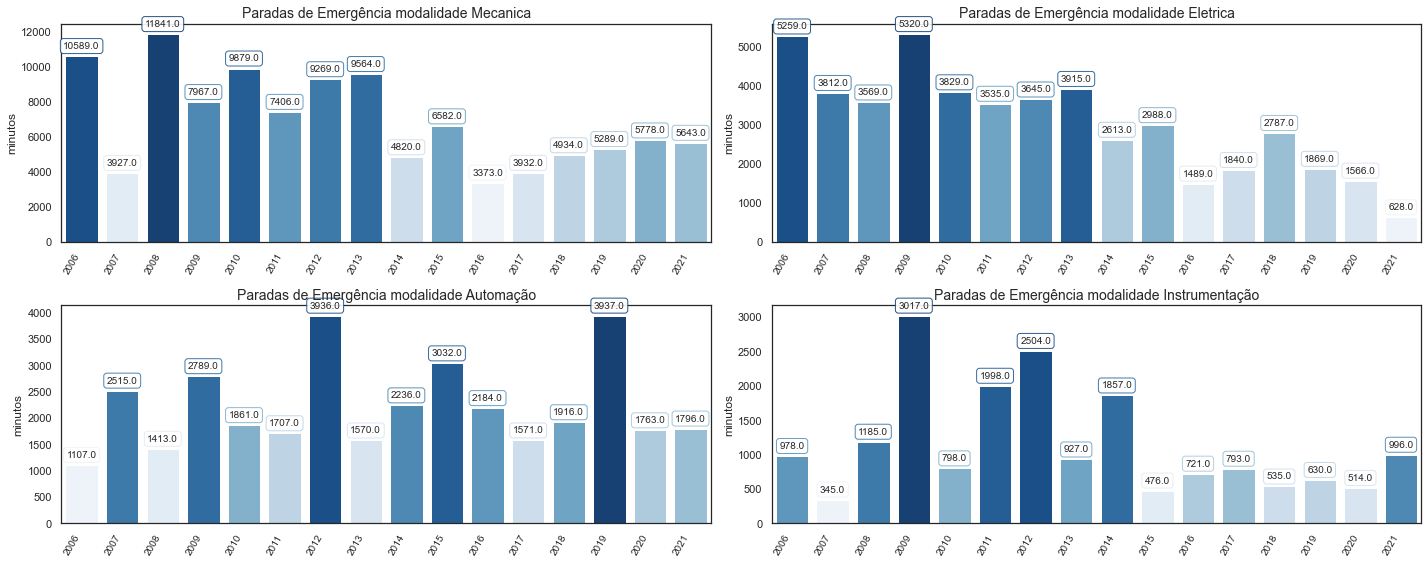

In [66]:
gridsize = (2,2)

fig = plt.figure(figsize=(20, 8))
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=1, rowspan=1)
ax2 = plt.subplot2grid(gridsize, (0, 1), colspan=1, rowspan=1)
ax3 = plt.subplot2grid(gridsize, (1, 0), colspan=1, rowspan=1)
ax4 = plt.subplot2grid(gridsize, (1, 1), colspan=1, rowspan=1)


################################################

grafico(df_o,ax1,'MM','Mecanica')
grafico(df_o,ax2,'ME','Eletrica')
grafico(df_o,ax3,'MA','Automação')
grafico(df_o,ax4,'IN','Instrumentação')

fig.tight_layout()

# Análise de MTTR e MTBF por modalidade de manutenção

In [67]:
def responsabilidades(df):           
    df['Modalidade'] = 'Externas'
    mask = df['Desc. Un. Resp. (PE)'].str.contains('PP-') == True
    column_name = 'Modalidade'
    df.loc[mask, column_name] = 'Setup'

    mask = df['Desc. Un. Resp. (PE)'].str.contains('ST-') == True
    column_name = 'Modalidade'
    df.loc[mask, column_name] = 'Setup'

    mask = df['Desc. Un. Resp. (PE)'].str.contains('FT-') == True
    column_name = 'Modalidade'
    df.loc[mask, column_name] = 'Setup'

    mask = df['Desc. Un. Resp. (PE)'].str.contains('OP-') == True
    column_name = 'Modalidade'
    df.loc[mask, column_name] = 'Operação'

    mask = df['Desc. Un. Resp. (PE)'].str.contains('MA-') == True
    column_name = 'Modalidade'
    df.loc[mask, column_name] = 'Manutenção'

    mask = df['Desc. Un. Resp. (PE)'].str.contains('MM-') == True
    column_name = 'Modalidade'
    df.loc[mask, column_name] = 'Manutenção'

    mask = df['Desc. Un. Resp. (PE)'].str.contains('MI-') == True
    column_name = 'Modalidade'
    df.loc[mask, column_name] = 'Manutenção'

    mask = df['Desc. Un. Resp. (PE)'].str.contains('ME-') == True
    column_name = 'Modalidade'
    df.loc[mask, column_name] = 'Manutenção'

    mask = df['Desc. Un. Resp. (PE)'].str.contains('INST') == True
    column_name = 'Modalidade'
    df.loc[mask, column_name] = 'Manutenção'


    mask = df['Desc. Motivo Parada (PE)'].str.contains('PREVE') == True
    column_name = 'Modalidade'
    df.loc[mask, column_name] = 'Manutenção'
    df.loc[mask,'Desc. Un. Resp. (PE)'] = 'MP'

    mask = df['Desc. Motivo Parada (PE)'].str.contains('GERA') == True
    column_name = 'Modalidade'
    df.loc[mask, column_name] = 'Manutenção'
    df.loc[mask,'Desc. Un. Resp. (PE)'] = 'RG'

    mask = df['Desc. Motivo Parada (PE)'].str.contains('NP-') == True
    column_name = 'Modalidade'
    df.loc[mask, column_name] = 'Não programada'

    return df

def emenda_paradas(df):
           
    df['Corr'] = df['Dt. Início (PE)'] + pd.to_timedelta(df['Tempo Parada Calculada (PE)'], unit='m')
    
    df['emenda'] = np.where((df['Dt. Início (PE)'] == df['Dt. Fim (PE)'].shift()) & (df['Desc. Motivo Parada (PE)'] == df['Desc. Motivo Parada (PE)'].shift()), 1, 0)            
    df.loc[(df['emenda']==0) & (df['emenda'].shift(-1)==1), 'emenda'] = 1

    df['grupo'] = 0
    df['grupo'] = df['grupo'].mask(df['emenda'] == 0, 'N' + df['emenda'].diff().fillna(df['emenda']).eq(0).cumsum().astype(str))
    df['grupo'] = df['grupo'].mask(df['emenda'] == 1, 'E' + df['emenda'].diff().fillna(df['emenda']).eq(-1).cumsum().astype(str))

    df['Acumulado'] = df.groupby('grupo')['Tempo Parada Calculada (PE)'].cumsum()

    df = df.groupby(['grupo']).agg({'Equipamento (PE)':'first',
                                    'Dt. Início (PE)':'first',
                                    'Dt. Fim (PE)':'last',
                                    'Tempo Parada Calculada (PE)':'sum',
                                    'Desc. Un. Resp. (PE)':'first',
                                    'Desc. Motivo Parada (PE)':'first',
                                    'Observação (PE)':'first',
                                    'Equipe (PE)':'first',
                                    'Semana':'first',
                                    'Causa Externa (PE)':'first',
                                    'Modalidade':'first',
                                    'Corr':'first',
                                    'emenda':'first',
                                    'Acumulado':'first'})

    df = df.drop(['Corr','emenda','Acumulado'],axis=1)
    
    return df

def troca_nome(df):
    df.loc[df['Desc. Un. Resp. (PE)'].str.contains("ME-MANUTENCAO ELETRICA"),'Desc. Un. Resp. (PE)'] = 'ME'
    df.loc[df['Desc. Un. Resp. (PE)'].str.contains("MM-MANUTENCAO MECANICA"),'Desc. Un. Resp. (PE)'] = 'MM'
    df.loc[df['Desc. Un. Resp. (PE)'].str.contains("MA-MANUTENCAO AUTOMACAO"),'Desc. Un. Resp. (PE)'] = 'MA'
    df.loc[df['Desc. Un. Resp. (PE)'].str.contains("IN- INSTRUMENTACAO"),'Desc. Un. Resp. (PE)'] = 'IN'
    return df

def colors_from_values(values, palette_name):
    # normalize the values to range [0, 1]           
    minimo = np.amin(values)
    maximo = np.amax(values)
    normalized = (values - minimo) / (maximo - minimo)
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    
    return np.array(palette).take(indices, axis=0)

def dgp(df_SIG,linha):
    
    df_dgp = df_SIG
    
    df_dgp = df_dgp.loc[df_dgp['Equipamento (PE)'].isin(linha)]

    df_dgp = responsabilidades(df_dgp) # insere coluna (Modalidade) com informações de Manutenção,setup,operação a
    df_dgp = emenda_paradas(df_dgp) # une as paradas que foram quebradas as 6:30 e 18:30
    df_dgp['Ano_mes'] = df_dgp['Dt. Início (PE)'].dt.strftime('%Y-%m')
    df_dgp['Ano'] = df_dgp['Dt. Início (PE)'].dt.strftime('%Y')

    df_dgp = df_dgp.reset_index()
    df_dgp = df_dgp.sort_values(by='Dt. Início (PE)')
    df_dgp = df_dgp.drop(columns=['grupo'])
    df_dgp.index = range(0,df_dgp.shape[0])

    df_dgp['Parada'] = 'Tempo DGP'

    df_dgp = df_dgp.loc[df_dgp['Dt. Início (PE)']>'2006-01-01']

    df_dgp = pd.pivot_table(df_dgp, values = 'Tempo Parada Calculada (PE)', index=['Ano'],
                                columns=['Parada'], aggfunc=np.sum)
    df_dgp = df_dgp.fillna(0)
    
    return df_dgp

def tempo_np(df_SIG,linha):
    
    df = df_SIG
    
    df = df.loc[df['Equipamento (PE)'].isin(linha)]

    df = responsabilidades(df) # insere coluna (Modalidade) com informações de Manutenção,setup,operação a
    df = emenda_paradas(df) # une as paradas que foram quebradas as 6:30 e 18:30
    
    df = df.loc[df['Modalidade']=='Não programada']
    
    df['Ano_mes'] = df['Dt. Início (PE)'].dt.strftime('%Y-%m')
    df['Ano'] = df['Dt. Início (PE)'].dt.strftime('%Y')

    df = df.reset_index()
    df = df.sort_values(by='Dt. Início (PE)')
    df = df.drop(columns=['grupo'])
    df.index = range(0,df.shape[0])

    df['Parada'] = 'Tempo NP'

    df = df.loc[df['Dt. Início (PE)']>'2006-01-01']

    df = pd.pivot_table(df, values = 'Tempo Parada Calculada (PE)', index=['Ano'],
                                columns=['Parada'], aggfunc=np.sum)
    df = df.fillna(0)
    
    return df

def disponibilidades(df_SIG,linha):  
    
    df_dgp = dgp(df_SIG,linha)
    df_np = tempo_np(df_SIG,linha)
        
    df_o = df_SIG.loc[df_SIG['Equipamento (PE)'].isin(linha)]
    
    df_o = df_o.loc[df_o['Modalidade']=='Manutenção']
    
    # Soma de tempo das paradas de linha
    df = df_o
    df_parada = pd.pivot_table(df, values = 'Tempo Parada Calculada (PE)', index=['Ano'],
                                columns=['Desc. Un. Resp. (PE)'], aggfunc=np.sum)
    df_parada = df_parada.fillna(0)
    df_parada['Tempo DGFM'] = df_parada.sum(axis=1)

    # Quantidade total de paradas de Linha
    df = df_o
    df_count = pd.pivot_table(df, values = 'Tempo Parada Calculada (PE)', index=['Ano'],
                                columns=['Desc. Un. Resp. (PE)'], aggfunc='count')
    df_count = df_count.fillna(0)
    df_count = df_count.rename(columns={'MM':'Quantidade MM','ME':'Quantidade ME','MA':'Quantidade MA','IN':'Quantidade IN'})
    df_count['Quantidade de Paradas'] = df_count.sum(axis=1)

    df = pd.merge(df_parada,df_count,how='outer', on=['Ano'])
    
    df['Dias no Ano'] = pd.to_datetime('31-12-' + df.index)
       
    df.iloc[-1, df.columns.get_loc('Dias no Ano')] = pd.to_datetime(dt.date.today())


    df['Minutos Ano'] = df['Dias no Ano'].dt.dayofyear*24*60
    df = df.drop(columns=['Dias no Ano'])

    
    df = pd.merge(df,df_dgp,how='outer', on=['Ano'])

    df['DGP'] = round(1-df['Tempo DGP']/df['Minutos Ano'],4)
    df['DGFM'] = round(1-df['Tempo DGFM']/df['Minutos Ano'],4)
    df['MTBF'] = round(((df['Minutos Ano'] - df['Tempo DGP'])/60)/df['Quantidade de Paradas'],2)
    df['MTTR'] = round(df['Tempo DGFM']/df['Quantidade de Paradas'],2)

    df = df[['DGP','DGFM','MTBF','MTTR']]
    return df

In [68]:
def mttr_mtbf(tipo,ax_,modalidade_especifica):
    
    linha_especifica = 'LPC1'
    df_SIG = pd.read_parquet(r'I:\Corporacao\GPC\04- LPC\Python\Dados\Paradas.parquet')

    df_SIG = responsabilidades(df_SIG) # insere coluna (Modalidade) com informações de Manutenção,setup,operação a
    df_SIG = emenda_paradas(df_SIG) # une as paradas que foram quebradas as 6:30 e 18:30
    df_SIG = troca_nome(df_SIG) # troca por responsabilidades MM, ME, MA, e IN
    df_SIG['Ano_mes'] = df_SIG['Dt. Início (PE)'].dt.strftime('%Y-%m')
    df_SIG['Ano'] = df_SIG['Dt. Início (PE)'].dt.strftime('%Y')

    df_SIG = df_SIG.reset_index()
    df_SIG = df_SIG.sort_values(by='Dt. Início (PE)')
    df_SIG = df_SIG.drop(columns=['grupo'])
    df_SIG.index = range(0,df_SIG.shape[0])

    #df_SIG = df_SIG.loc[df_SIG['Desc. Motivo Parada (PE)'].str.contains(modalidade_especifica,case=False)]
    df_SIG = df_SIG.loc[df_SIG['Desc. Un. Resp. (PE)'].str.contains(modalidade_especifica,case=False)]
    df_SIG = df_SIG.loc[df_SIG['Equipamento (PE)'].str.contains(linha_especifica,case=False)]

    df_DISP = disponibilidades(df_SIG,[linha_especifica])
    
    ########################################################
    
    if tipo == 'MTTR':
        df_DGP = df_DISP[[col for col in df_DISP.columns if tipo in col]].T
        unidade = 'min'
    elif tipo == 'MTBF':
        df_DGP = df_DISP[[col for col in df_DISP.columns if tipo in col]].T
        unidade = 'h'
        
       
    tabela = df_DGP.T
    tabela= tabela.reset_index()
    tabela['Ano'] = tabela['Ano'].astype(str)

    sns.lineplot(x='Ano',
                y=tipo,
                color = 'darkblue',
                marker = 'o',
                ax = ax_,
                data=tabela)

    plt.xticks(rotation=60, horizontalalignment='right')
    
    if modalidade_especifica == 'MM':
        titulo = tipo + ' - Modalidade Mecânica'
    elif modalidade_especifica == 'ME':
        titulo = tipo + ' - Modalidade Elétrica'
    elif modalidade_especifica == 'MA':
        titulo = tipo + ' - Modalidade Automação'
    elif modalidade_especifica == 'IN':
        titulo = tipo + ' - Modalidade Instrumentação' 
    
    ax_.set_title(titulo, fontsize=14)
    ax_.set_xlabel('', fontsize=12)
    ax_.set_ylabel(unidade, fontsize=12)


    None
    


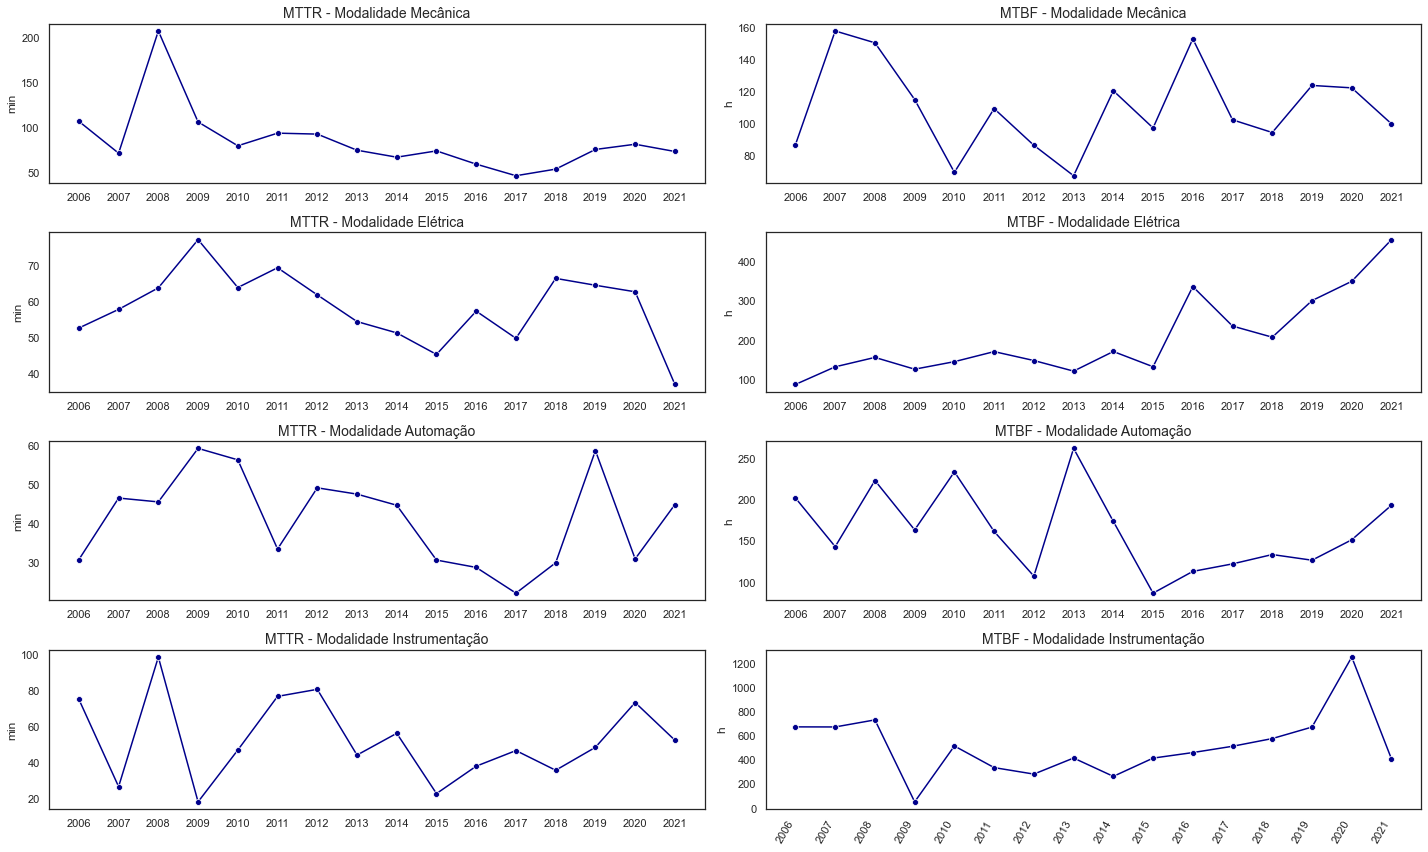

In [69]:
gridsize = (4,2)

fig = plt.figure(figsize=(20, 12))
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=1, rowspan=1)
ax2 = plt.subplot2grid(gridsize, (0, 1), colspan=1, rowspan=1)
ax3 = plt.subplot2grid(gridsize, (1, 0), colspan=1, rowspan=1)
ax4 = plt.subplot2grid(gridsize, (1, 1), colspan=1, rowspan=1)
ax5 = plt.subplot2grid(gridsize, (2, 0), colspan=1, rowspan=1)
ax6 = plt.subplot2grid(gridsize, (2, 1), colspan=1, rowspan=1)
ax7 = plt.subplot2grid(gridsize, (3, 0), colspan=1, rowspan=1)
ax8 = plt.subplot2grid(gridsize, (3, 1), colspan=1, rowspan=1)

mttr_mtbf('MTTR',ax1,'MM')
mttr_mtbf('MTBF',ax2,'MM')
mttr_mtbf('MTTR',ax3,'ME')
mttr_mtbf('MTBF',ax4,'ME')
mttr_mtbf('MTTR',ax5,'MA')
mttr_mtbf('MTBF',ax6,'MA')
mttr_mtbf('MTTR',ax7,'IN')
mttr_mtbf('MTBF',ax8,'IN')

fig.tight_layout()